In [1]:
import sys
import os
import pandas as pd
import numpy as np
import networkx as nx
from Swing.util.Evaluator import Evaluator
from Swing.util.lag_identification import get_experiment_list, xcorr_experiments, calc_edge_lag
from nxpd import draw
from nxpd import nxpdParams
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import fisher_exact, linregress, ttest_rel, mannwhitneyu, ttest_ind
import seaborn as sns

%matplotlib inline

## Functions!

#### Note: Several of the functions do not pass variables correctly. Code will need to be cleaned if shared

In [2]:
def is_square(n):
    """
    Determine if a number is a perfect square
    :param n: int or float
        The number to check
    :return: Boolean
        Return True if the number is a perfect square
    """
    return np.sqrt(n).is_integer()


def get_factors(n):
    """
    Calculate the factors of a number
    :param n: int
        The number to be factored
    :return: list
        A sorted list of the unique factors from smallest to largest
    """
    factor_list = np.array([[i, n // i] for i in range(1, int(n ** 0.5) + 1) if n % i == 0]).flatten().astype(int)
    return sorted(factor_list.tolist())


def calc_subplot_dimensions(x):
    """
    Calculate the dimensions for a matplotlib subplot object.
    :param x: int
        Number of plots that need to be made
    :return: rows, columns
        The number of rows and columns that should be in the subplot
    """
    if x <= 3:
        rows = x
        columns = 1
    else:
        factor_list = get_factors(x)
        while len(factor_list) <= 2 and not is_square(x):
            x += 1
            factor_list = get_factors(x)
        if is_square(x):
            rows = int(np.sqrt(x))
            columns = int(np.sqrt(x))

        else:
            rows = factor_list[int(len(factor_list)/2-1)]
            columns = factor_list[int(len(factor_list)/2)]

    return rows, columns


def get_true_edges(gold_filename):
    evaluator = Evaluator(gold_filename, '\t')
    edges = evaluator.gs_flat.tolist()
    return edges, evaluator


def get_edge_lags(data_filename):
    df = pd.read_csv(data_filename, sep="\t")
    gene_list = df.columns.values[1:].tolist()
    experiment_list = get_experiment_list(data_filename, 21, 10)
    xcorr_array = xcorr_experiments(experiment_list)
    lags = calc_edge_lag(xcorr_array, gene_list, 0.1, 0.5, timestep=1)
    return lags, df


def get_network_changes(pickle_filename, edge_str='regulator-target', base_str='rank_importance_RF-td_21',
                        shortener_str='rank_importance_', replace=''):
    results_df = pd.read_pickle(pickle_filename)
    edges = results_df[edge_str].values
    baseline = results_df[base_str].values

    rank_df = pd.DataFrame()
    rank_df[edge_str] = edges
    rank_df[('Base_%s' %replace)] = baseline
    for column in results_df.columns:
        if column != edge_str and column!=base_str:
            short_name = column.replace(shortener_str, replace)
            rank_df[short_name] = results_df[column].values
    rank_df.set_index(['regulator-target'], inplace=True)
    diff_df = (rank_df.T.iloc[0]-rank_df.T).T
    parameters = set(rank_df.columns[1:].values)
    return diff_df, rank_df, parameters


def get_network_data(goldstandard, timeseries, ignore_self=True):
    # Get true network
    true_edges, evaluator = get_true_edges(goldstandard)
    dg = nx.DiGraph()
    dg.add_edges_from(true_edges)
    
    #Network statistics - deprecated
    #degree = nx.degree_centrality(dg)
    #b_cent = pd.DataFrame.from_dict({k: [v] for k, v in nx.edge_betweenness_centrality(dg).items()}, 'index')
    #b_cent.columns = ['Bcent']
    
    #Calculate edge lags
    edge_lags, data = get_edge_lags(timeseries)
    if ignore_self:
        edge_lags = edge_lags[edge_lags['Parent'] != edge_lags['Child']]
    edge_df = pd.DataFrame(edge_lags['Lag'].values, index=edge_lags['Edge'].values, columns=['Lag'])

    return true_edges, edge_df, data, dg, evaluator

def get_signed_edges(signed):
    df = pd.read_csv(signed, sep='\t', header=None)
    df['regulator-target'] = list(zip(df[0], df[1]))
    df.set_index(['regulator-target'], inplace=True)
    df.drop([0, 1], axis=1, inplace=True)
    df.columns=['sign']
    return df

def calc_scores(ranking_df):
    filtered_ranks = ranking_df.copy()
    filtered_ranks.reset_index(level=0, inplace=True)
    roc = []
    aupr = []
    for c in filtered_ranks.columns[1:]:
        filtered_ranks.sort_values(filtered_ranks.columns[1], inplace=True)
        roc.append(evaluator.calc_roc(filtered_ranks.iloc[:, :2])[2].values[-1])
        aupr.append(evaluator.calc_pr(filtered_ranks.iloc[:, :2])[2].values[-1])
        filtered_ranks.drop(c, axis=1, inplace=True)
    return roc, aupr

def calc_promotion(change_df, columns):
    t_promoted = np.sum(change_df.loc[:, columns].values > 0, axis=0)
    t_demoted = np.sum(change_df.loc[:, columns].values < 0, axis=0)
    t_same = np.sum(change_df.loc[:, columns].values == 0, axis=0)

    t_lagged = change_df[change_df['Lag'] > 0]
    l_promoted = np.sum(t_lagged.loc[:, columns].values > 0, axis=0)
    l_demoted = np.sum(t_lagged.loc[:, columns].values < 0, axis=0)
    l_same = np.sum(t_lagged.loc[:, columns].values == 0, axis=0)
    rows = ['true+', 'true-', 'true=', 'lag+', 'lag-', 'lag=']
    return pd.DataFrame([t_promoted, t_demoted, t_same, l_promoted, l_demoted, l_same], index=rows, columns=columns).T

def get_net_stats(dg):
    g = dg.to_undirected()
    assort = nx.degree_pearson_correlation_coefficient(dg)
    if np.isnan(assort):
        assort = 0
    clust = nx.average_clustering(g)
    trans= nx.transitivity(g)
    try:
        rad = nx.radius(g)
    except nx.NetworkXError:
        rad = 0
    try:
        diam = nx.diameter(g)
    except nx.NetworkXError:
        diam = 0
    return [assort, clust, trans, rad, diam]

def get_c_table(summary_df):
    """
    C table format: [[lagged_promoted, lagged_not_promoted],
                 [not_lagged_promoted, not_lagged_not_promoted]]
    """

    c_table = np.array([[summary_df['lag+'], summary_df['lag-']+summary_df['lag=']],
                        [summary_df['true+']-summary_df['lag+'],
                         summary_df['true-']+summary_df['true=']-summary_df['lag-']-summary_df['lag=']]])
    c_table = np.array([c_table[:, :, ii] for ii in range(c_table.shape[2])])
    return c_table

def get_enrichment(c_array, conditions):
    pvals = pd.DataFrame([fisher_exact(c_tab)[1] for c_tab in c_array], index=conditions, columns=['pval'])
    return pvals
    

### Compile results

In [3]:
lag_range = {'ml_0': [0, 1], 'ml_1': [0, 2], 'ml_2': [0, 3], 'ml_3': [1, 2], 'ml_4': [1, 4], 'ml_5': [2, 3]}
num_nets = 20
methods = ['Dionesus', 'RF']
replace_dict = {'Dionesus':'D', 'RF':'RF'}
models = ['Ecoli', 'Yeast']
result_types = ['te_change', 'te_rank', 'roc', 'pr']
# s_dict = {method:{model:{net:{"aupr": pd.DataFrame(), "auroc":pd.DataFrame(), 
#                               "te_change":pd.DataFrame(), "te_rank":pd.DataFrame()} 
#                          for net in range(1, num_nets+1)} for model in models} for method in methods}
s_dict = {}
for ii, method in enumerate(methods):
    s_dict[method] = {"aupr": pd.DataFrame(), "auroc":pd.DataFrame(), 
                      "te_change":pd.DataFrame(), "te_rank":pd.DataFrame()}
    for model in models:
        s_dict[method][model] = {"aupr": pd.DataFrame(), "auroc":pd.DataFrame(), 
                                 "te_change":pd.DataFrame(), "te_rank":pd.DataFrame()}
        for net in range(1, num_nets+1):
            s_dict[method][model][net] = {"aupr": pd.DataFrame(), "auroc":pd.DataFrame(), 
                                          "te_change":pd.DataFrame(), "te_rank":pd.DataFrame()}
            short = 'rank_importance_%s' %method
            pickle_file = "%s_net%i_%s_promotion.pkl" % (model, net, method.lower())
            base_str = ('rank_importance_%s-td_21' %method)
            
            roc_df = pd.DataFrame()
            pr_df = pd.DataFrame()
            # Get the network information
            gold_file = "../data/gnw_insilico/network_data/%s/%s-%i_goldstandard.tsv" % (model, model, net)
            signed_file = gold_file.replace('.tsv', '_signed.tsv')
            data_file = "../data/gnw_insilico/network_data/%s/%s-%i_timeseries.tsv" % (model, model, net)
            true_edges, edge_df, data, dg, evaluator = get_network_data(gold_file, data_file)
            signed_edges = get_signed_edges(signed_file)
        
            change, ranks, params = get_network_changes(pickle_file, base_str= base_str, 
                                                        shortener_str=short, replace=replace_dict[method])
            
            change_df = change.reindex_axis(sorted(change.columns), axis=1)
            ranks_df = ranks.reindex_axis(sorted(ranks.columns), axis=1)
            conditions = change_df.columns.values
            s_dict[method][model][net]['rank'] = ranks_df
            s_dict[method][model][net]['rank_change'] = change_df
        
            # Calculate the auroc and aupr for each parameter set of the network
            roc_df[model + str(net)], pr_df[model + str(net)]= calc_scores(ranks_df)
            roc_df.index = conditions
            pr_df.index = conditions
            s_dict[method][model][net]['auroc'] = roc_df.T
            s_dict[method][model][net]['aupr'] = pr_df.T
            
            # Compile results
            full_change = pd.concat([edge_df, change_df], axis=1, join='inner')
            full_rank = pd.concat([edge_df, ranks_df], axis=1, join='inner')
            te_rank = pd.concat([signed_edges, full_rank[full_rank.index.isin(true_edges)]], 
                                        axis=1, join='inner')
            te_change = pd.concat([signed_edges, full_change[full_change.index.isin(true_edges)]],
                                           axis=1, join='inner')
            promotions = calc_promotion(te_change, conditions)
            contingency = get_c_table(promotions)                
            s_dict[method][model][net]['conditions'] = conditions
            s_dict[method][model][net]['change'] = full_change
            s_dict[method][model][net]['rank'] = full_rank
            s_dict[method][model][net]['te_change'] = te_change
            s_dict[method][model][net]['te_rank'] = te_rank
            s_dict[method][model][net]['promotion'] = promotions
            s_dict[method][model][net]['contingency'] = contingency
            s_dict[method][model][net]['enrich_pvals'] = get_enrichment(contingency, conditions)
            s_dict[method][model][net]['stats'] = pd.DataFrame(get_net_stats(dg), index=['assort', 'clust', 
                                                                                         'trans', 'rad', 'diam'])
            # Summarize it for each model organism
            s_dict[method][model]['aupr'] = pd.concat([s_dict[method][model]['aupr'], pr_df.T], join='inner')
            s_dict[method][model]['auroc'] = pd.concat([s_dict[method][model]['auroc'], roc_df.T], join='inner')
            s_dict[method][model]['te_change'] = pd.concat([s_dict[method][model]['te_change'], te_change], join='outer')
            s_dict[method][model]['te_rank'] = pd.concat([s_dict[method][model]['te_rank'], te_rank], join='outer')
        auroc = s_dict[method][model]['auroc']
        aupr = s_dict[method][model]['aupr']
        s_dict[method][model]['auroc_diff'] = pd.DataFrame((auroc.values.T - auroc.values[:, 0]).T, 
                                                            index=auroc.index, columns=auroc.columns)
        s_dict[method][model]['aupr_diff'] = pd.DataFrame((aupr.values.T - aupr.values[:, 0]).T, 
                                                            index=aupr.index, columns=aupr.columns)
        s_dict[method][model]['promotion'] = calc_promotion(s_dict[method][model]['te_change'], conditions)
        s_dict[method][model]['contingency'] = get_c_table(s_dict[method][model]['promotion'])
        s_dict[method][model]['enrich_pvals'] = get_enrichment(s_dict[method][model]['contingency'], conditions)
        
        #Summarize it for each method
        s_dict[method]['aupr'] = pd.concat([s_dict[method]['aupr'], s_dict[method][model]['aupr']], join='inner')
        s_dict[method]['auroc'] = pd.concat([s_dict[method]['auroc'], s_dict[method][model]['auroc']], join='inner')
        s_dict[method]['te_change'] = pd.concat([s_dict[method]['te_change'], 
                                                 s_dict[method][model]['te_change']], join='outer')
        s_dict[method]['te_rank'] = pd.concat([s_dict[method]['te_rank'], s_dict[method][model]['te_rank']], 
                                              join='outer')
    
    auroc = s_dict[method]['auroc']
    aupr = s_dict[method]['aupr']
    s_dict[method]['auroc_diff'] = pd.DataFrame((auroc.values.T - auroc.values[:, 0]).T, 
                                                        index=auroc.index, columns=auroc.columns)
    s_dict[method]['aupr_diff'] = pd.DataFrame((aupr.values.T - aupr.values[:, 0]).T, 
                                                            index=aupr.index, columns=aupr.columns)
    s_dict[method]['promotion'] = calc_promotion(s_dict[method]['te_change'], s_dict[method]['aupr'].columns)
    s_dict[method]['contingency'] = get_c_table(s_dict[method]['promotion'])
    s_dict[method]['enrich_pvals'] = get_enrichment(s_dict[method]['contingency'], conditions)

## Overall Results

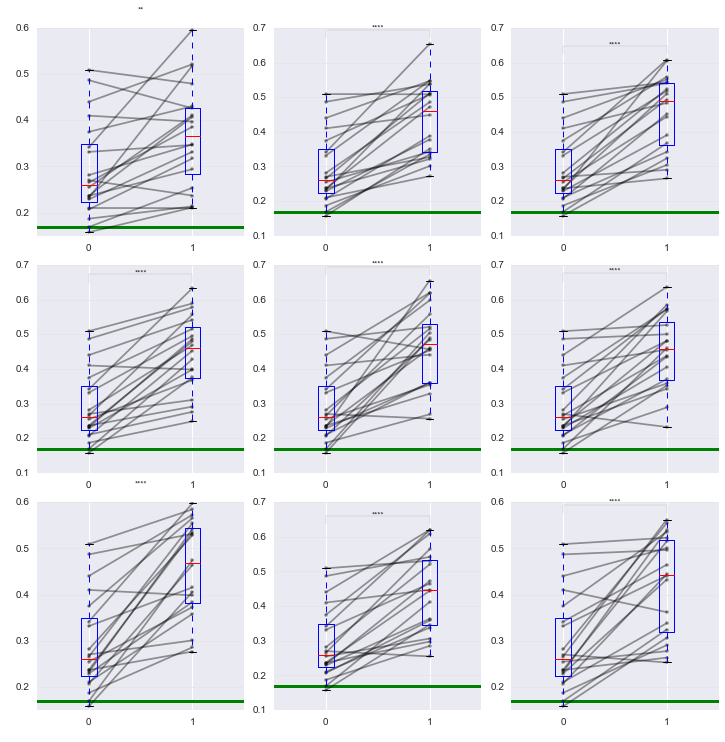

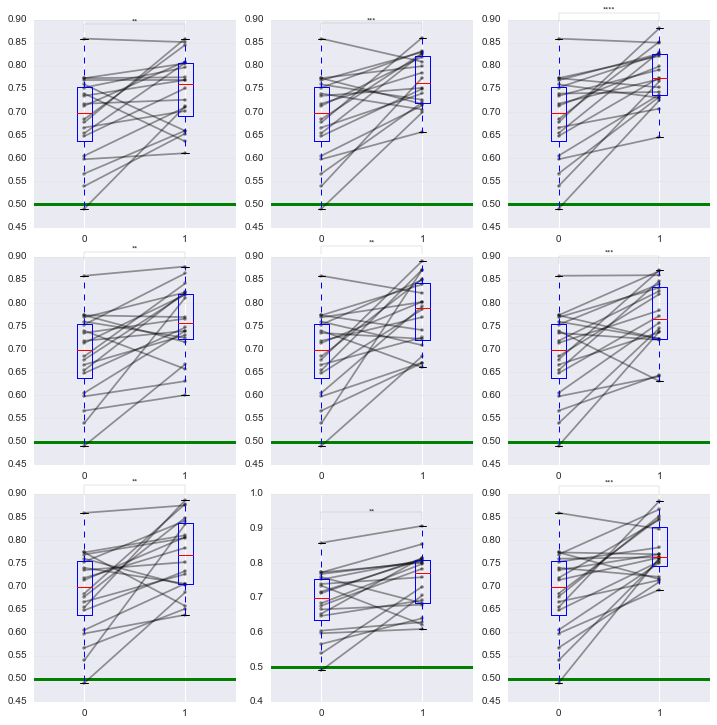

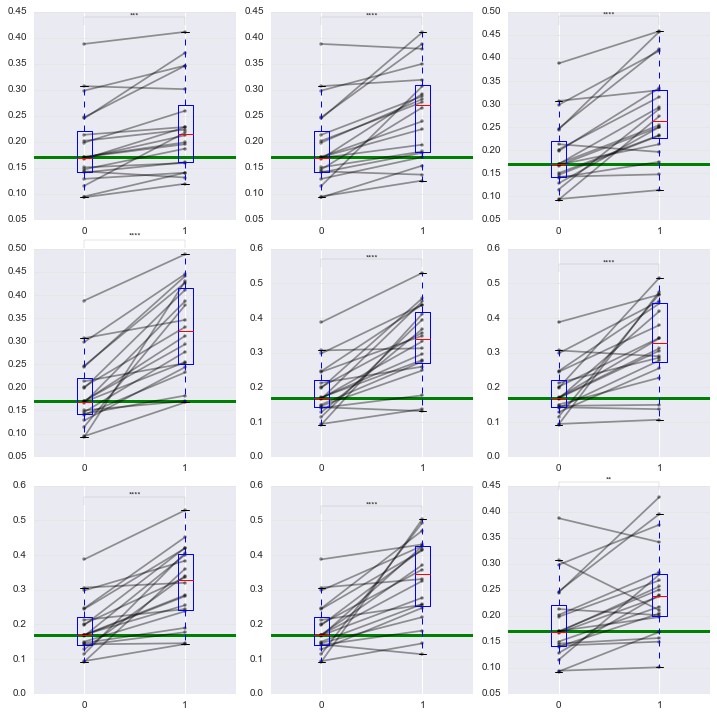

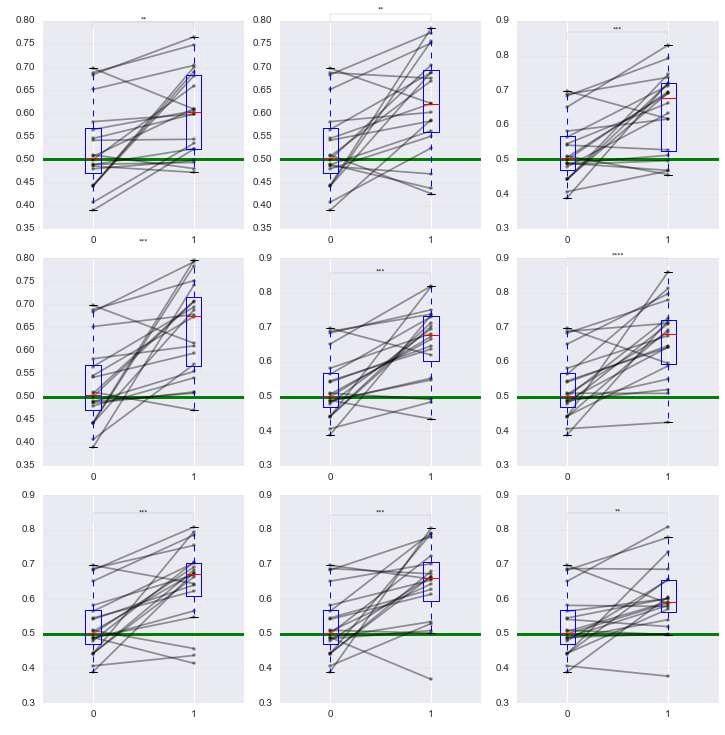

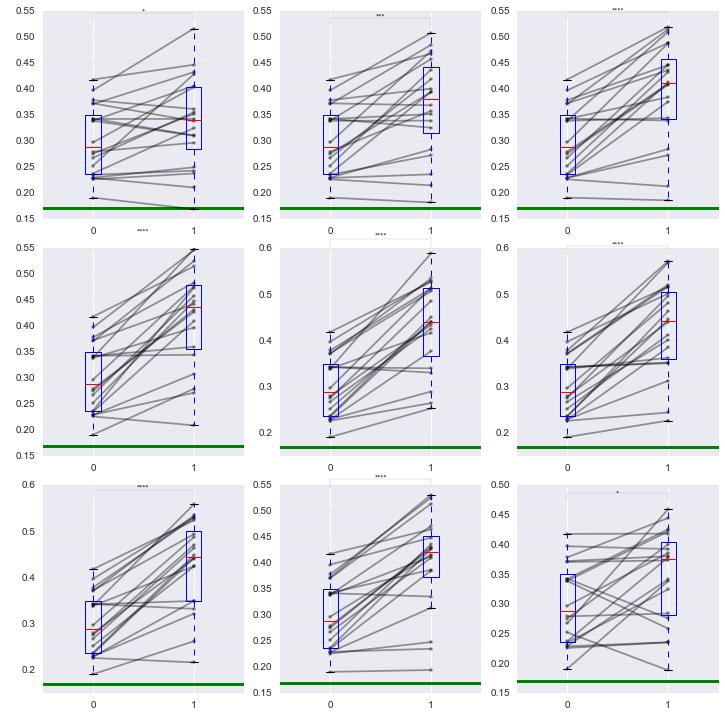

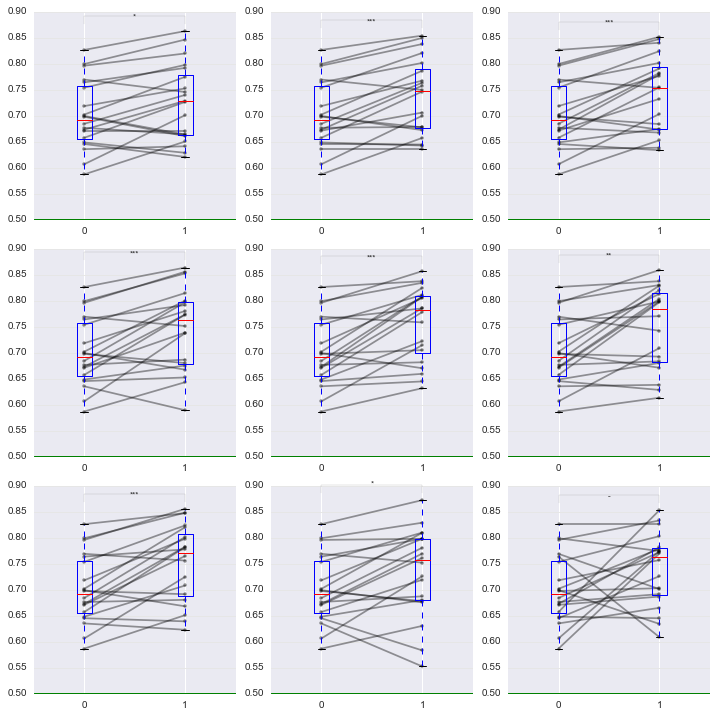

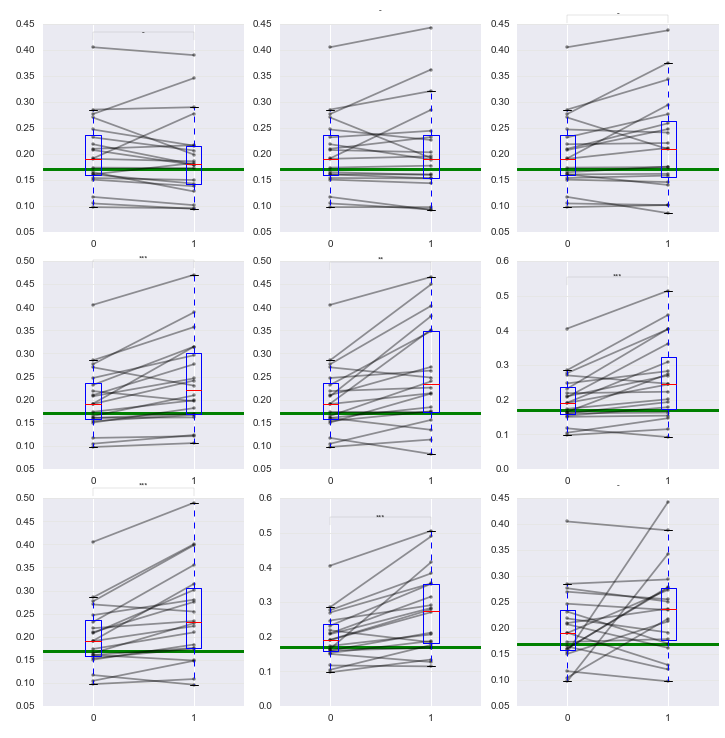

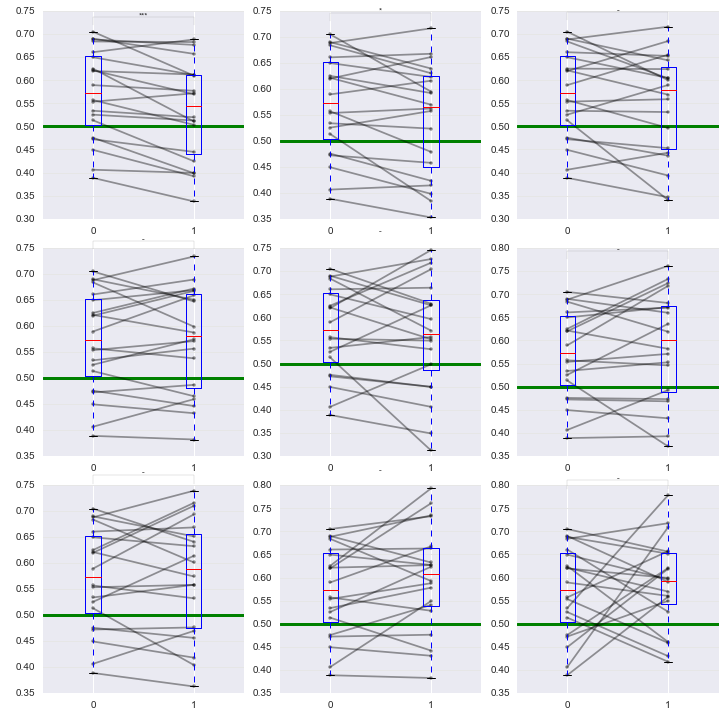

In [62]:
"""
Some columns are labeled as RF-td_2, RF-td10, RF-ml_1, etc.

td_X refers to a window size of X. For all these networks, the rest of the parameters are the same:
min_lag is 1, max lag is 3, except RF-td 21, which is just regular random forest.

ml_X refers to a set of min_lags/max_lags for each X.
if X = 0; min_lag = 0, max_lag = 1
elif X = 1; min_lag = 0, max_lag = 2
elif X = 2; min_lag = 0, max_lag = 3
elif X = 3; min_lag = 1, max_lag = 2
elif X = 4; min_lag = 1, max_lag = 4
elif X = 5; min_lag = 2, max_lag = 3
"""
from matplotlib import rcParams
from matplotlib.patches import Polygon

params = {
   'axes.labelsize': 8,
   'font.size': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [2.5, 4.5]
}

def stars(p):
    if p < 0.0001:
        return "****"
    elif (p < 0.001):
        return "***"
    elif (p < 0.01):
        return "**"
    elif (p < 0.05):
        return "*"
    else:
        return "-"


rcParams.update(params)
import brewer2mpl
bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
colors = bmap.mpl_colors

methods = ['RF', 'Dionesus']
models = ['Yeast', 'Ecoli']
scores = ['aupr', 'auroc']
bprops = dict(linewidth=3)
mprops = dict(linewidth=3, color='r')
wprops = dict(linewidth=3, linestyle='--')
for method in methods:
    diffs = pd.DataFrame()
    for model in models:
        for score in scores:
#             print('\n', method, model, score)
            avg_diff = pd.DataFrame(np.mean(s_dict[method][model][(score+'_diff')], axis=0), 
                                    columns=[model+"_"+score])
            avg_diff['_'.join([model, score, 'pval'])] = [ttest_rel(s_dict[method][model][score].iloc[:,0], 
                                                                    s_dict[method][model][score].iloc[:, ii]).pvalue 
                                                          for ii in range(len(s_dict[method][model][score].columns))]
            x_array = np.array([[0]*len(s_dict[method][model][score]), [1]*len(s_dict[method][model][score])])
            f = plt.figure(figsize=(10,10))
            for ii, idx in enumerate(avg_diff.index):
                if ii == 0:
                    continue
                y_array = np.array([s_dict[method][model][score].iloc[:,0], s_dict[method][model][score].iloc[:,ii]])
                ax = f.add_subplot(3, 3, ii)
                ax.plot(x_array, y_array, '.-', c='k', alpha=0.4, zorder=2)
                if score == 'aupr':
                    ax.plot([-0.50, 1.5], [.17, .17], c='g', lw=3, zorder=1)
                else:
                    ax.plot([-0.50, 1.5], [0.5, 0.5], c='g', lw=3, zorder=1)
                p_value = avg_diff.iloc[ii, 1]
                s = stars(p_value)
                bp = ax.boxplot(y_array.T, positions=[0, 1])
                y_max = np.max(np.concatenate((y_array[0], y_array[1])))
                y_min = np.min(np.concatenate((y_array[0], y_array[1])))
                ax.annotate("", xy=(0, y_max+.01), xycoords='data',
                           xytext=(1, y_max+.01), textcoords='data',
                           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                                           connectionstyle="bar,fraction=0.1"))
                ax.text(0.5, y_max + abs(y_max - y_min)*0.1, stars(p_value),
                       horizontalalignment='center',
                       verticalalignment='center')
#                 for i in range(0, len(bp['boxes'])):
#                     bp['boxes'][i].set_color(colors[i])
#                     # we have two whiskers!
#                     bp['whiskers'][i*2].set_color(colors[i])
#                     bp['whiskers'][i*2 + 1].set_color(colors[i])
#                     bp['whiskers'][i*2].set_linewidth(2)
#                     bp['whiskers'][i*2 + 1].set_linewidth(2)
#                     # top and bottom fliers
#                     # (set allows us to set many parameters at once)
#                     bp['fliers'][i].set(markerfacecolor=colors[i],
#                                    marker='o', alpha=0.75, markersize=6,
#                                    markeredgecolor='none')
#                     bp['fliers'][i].set(markerfacecolor=colors[i],
#                                    marker='o', alpha=0.75, markersize=6,
#                                    markeredgecolor='none')
#                     bp['medians'][i].set_color('black')
#                     bp['medians'][i].set_linewidth(3)
#                     # and 4 caps to remove
#                     for c in bp['caps']:
#                         c.set_linewidth(0)
#                 for i in range(len(bp['boxes'])):
#                     box = bp['boxes'][i]
#                     box.set_linewidth(0)
#                     boxX = []
#                     boxY = []
#                     for j in range(5):
#                         boxX.append(box.get_xdata()[j])
#                         boxY.append(box.get_ydata()[j])
#                         boxCoords = zip(boxX,boxY)
#                         print(boxCoords)
#                         boxPolygon = Polygon(boxCoords, facecolor = colors[i], linewidth=0)
#                         ax.add_patch(boxPolygon)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.get_xaxis().tick_bottom()
                ax.get_yaxis().tick_left()
                ax.tick_params(axis='x', direction='out')
                ax.tick_params(axis='y', length=0)
                ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
                ax.set_axisbelow(True)
                ax.set_xlim([-0.5, 1.5])
#                 ax.set_title(' '.join([idx, model, score]))
            plt.tight_layout()
        
            diffs = pd.concat([diffs, avg_diff], axis=1)

## Lag Promotion

[ 0.  2.  4.  4.  5.  5.  6.  5.  4.  4.]
[ 0.   2.   2.5  2.   3.   2.   3.   2.  -1.   3.5]
MannwhitneyuResult(statistic=32657.5, pvalue=0.079259975010566752)


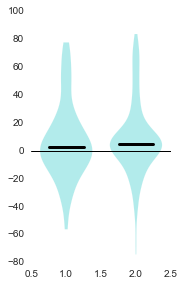

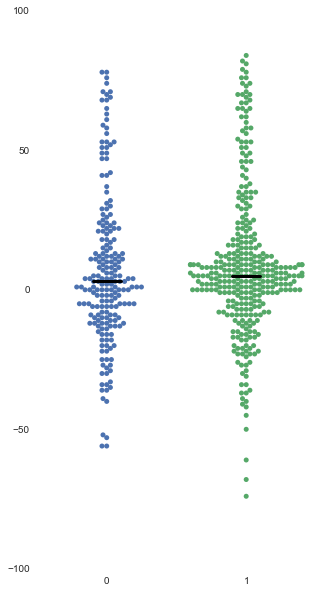

In [55]:
nl = s_dict['RF']['te_change'][(s_dict['RF']['te_change']["Lag"]==0) & (s_dict['RF']['te_rank']["Base_RF"]<90)]
l = s_dict['RF']['te_change'][(s_dict['RF']['te_change']["Lag"]>0) & (s_dict['RF']['te_rank']["Base_RF"]<90)]
print(np.median(l.iloc[:, 2:], axis=0))
print(np.median(l.iloc[:, 2:], axis=0) - np.median(nl.iloc[:, 2:], axis=0))
cond = 'RF-ml_4'
plt.plot([0.5, 2.5], [0, 0], c='k', lw=1)
vp =plt.violinplot([nl[cond].values, l[cond].values], showextrema=False, widths=0.75, points=200)
for pc in vp['bodies']:
    pc.set_facecolor('c')
    pc.set_edgecolor('w')
plt.plot([0.75, 1.25], [np.median(nl[cond].values), np.median(nl[cond].values)], c='k', lw=3)
plt.plot([1.75, 2.25], [np.median(l[cond].values), np.median(l[cond].values)], c='k', lw=3)
ax = plt.gca()
ax.set_axis_bgcolor('w')
print(mannwhitneyu(nl[cond].values, l[cond].values))

plt.figure(figsize=(5,10))
ax = sns.swarmplot(data = [nl[cond].values, l[cond].values], size=5)
ax.plot([-0.10, 0.10], [np.median(nl[cond].values), np.median(nl[cond].values)], c='k', lw=3, zorder=10)
ax.plot([0.90, 1.10], [np.median(l[cond].values), np.median(l[cond].values)], c='k', lw=3, zorder=10)
ax.set_axis_bgcolor('w')

## Meta analysis to determine what predicts edge promotion

In [6]:
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor,
                              GradientBoostingClassifier, ExtraTreesRegressor)
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, classification_report, mean_squared_error
from sklearn.cross_validation import train_test_split

In [7]:
# Combine data
methods = ['Dionesus', 'RF']
models = ['Ecoli', 'Yeast']

#Dionesus = 1, RF = 0
#Ecoli = 1, Yeast = 0
#Signs : + = 1, - = 0

temp_summary = pd.DataFrame()
summary_df = pd.DataFrame()

for m in methods:
    temp_summary = pd.DataFrame()
    for mod in models:
        temp = s_dict[m][mod]['te_change'].copy()
        temp.columns = [c.split('-')[1] if '-' in c else c for c in temp.columns.values]
        drop_col = 'Base_D' if m=='Dionesus' else 'Base_RF'
        temp.drop(drop_col, axis=1, inplace=True)
        if mod == 'Ecoli':
            temp.insert(0, 'model', np.ones(len(temp)))
        else:
            temp.insert(0, 'model', np.zeros(len(temp)))
        temp_summary = pd.concat([temp_summary, temp])
    if m == 'Dionesus':
        temp_summary.insert(0, 'method', np.ones(len(temp_summary)))
    else:
        temp_summary.insert(0, 'method', np.zeros(len(temp_summary)))
    summary_df = pd.concat([summary_df, temp_summary])
summary_df.replace(['-', '+'], [0, 1], inplace=True)

In [8]:
print(summary_df.columns[:4].values)
X = summary_df.iloc[:, :4]
for ii in range(9):
    print(summary_df.columns[ii+4])
    y = summary_df.iloc[:, ii+4].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    rfr = RandomForestRegressor(1000)
#     rfr = ExtraTreesRegressor(1000, n_jobs=-1)
    rfr.fit(X_train, y_train)
    r2 = rfr.score(X_test, y_test)
    print(len(y_test), r2, rfr.feature_importances_)

['method' 'model' 'sign' 'Lag']
ml_0
110 0.0101524794932 [ 0.20852788  0.18412129  0.15687639  0.45047444]
ml_1
110 0.0537641579899 [ 0.21744592  0.17279156  0.15800307  0.45175944]
ml_2
110 0.0299109371591 [ 0.22248683  0.17539729  0.15640892  0.44570696]
ml_3
110 -0.0432822789649 [ 0.16058361  0.17265463  0.187053    0.47970876]
ml_4
110 -0.0386530225045 [ 0.16403883  0.1869669   0.17364789  0.47534638]
ml_5
110 -0.0899944236524 [ 0.15275707  0.17648781  0.18814504  0.48261009]
td_10
110 -0.0447316094598 [ 0.15010546  0.1906785   0.18484219  0.47437386]
td_15
110 -0.0231679956865 [ 0.13345027  0.15632594  0.16195305  0.54827074]
td_2
110 -0.013489577618 [ 0.13251244  0.170295    0.21024461  0.48694794]


In [9]:
X = summary_df.iloc[:, :4]
for ii in range(9):
    print(summary_df.columns[ii+4])
    y = summary_df.iloc[:, ii+4].values.copy()
    y[y>0] = 1
    y[y<0] = -1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#     rfr = RandomForestClassifier(1000)
    rfr = GradientBoostingClassifier(n_estimators=1000, random_state=0)
    rfr.fit(X_train, y_train)
    rfr.predict_log_proba(X_test)
    print(classification_report(y_test, rfr.predict(X_test), target_names=['-1', '0', '1']))

ml_0
             precision    recall  f1-score   support

         -1       0.61      0.30      0.41       155
          0       0.00      0.00      0.00        16
          1       0.57      0.85      0.68       192

avg / total       0.56      0.58      0.53       363

ml_1
             precision    recall  f1-score   support

         -1       0.65      0.25      0.36       141
          0       0.00      0.00      0.00        23
          1       0.59      0.91      0.72       199

avg / total       0.57      0.60      0.53       363

ml_2
             precision    recall  f1-score   support

         -1       0.60      0.21      0.31       142
          0       0.00      0.00      0.00        24
          1       0.58      0.91      0.71       197

avg / total       0.55      0.58      0.51       363

ml_3
             precision    recall  f1-score   support

         -1       0.73      0.08      0.14       140
          0       0.00      0.00      0.00        22
          1     

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
